# Feature Engineering

This notebook is used to explore the feature set and create an optimal set.  I previously had a misunderstanding of the difference between categorical and quantitive variables so I intend to remedy this in this notebook and explain why.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import features

In [2]:
train_raw = pd.read_csv('../data/train.csv', header=0)
test_raw = pd.read_csv('../data/test.csv', header=0)
data_raw = pd.concat([train_raw, test_raw])

# Original Features

This is the feature set originally used in the second attempt.  I am recording it here so that I have a record of the transformations I did any why I made those choices. I have included a Pearson correlation heatmap to show that I originally included heavily correlated features.

In [3]:
data_raw['Fam_size'] = data_raw['SibSp'] + data_raw['Parch'] + 1

titles = ['Mr.', 'Miss.', 'Mrs.', 'Master.']
data_raw['Surname'] = data_raw['Name'].str.extract('(,\s)(.*\.)', expand=False)[1]
data_raw.loc[~data_raw['Surname'].isin(titles),'Surname'] = 'Rare'
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fam_size', 'Surname']
numerical_features = ['Age', 'Fare']
target = 'Survived'
data_clean = features.decision_tree_preprocessing(data_raw, 
                                                  target,
                                                  categorical_features=categorical_features, 
                                                  numerical_features=numerical_features, 
                                                  drop_na_columns=['Embarked'])
data_clean['AgeXFare'] = data_clean['Age'] * data_clean['Fare']

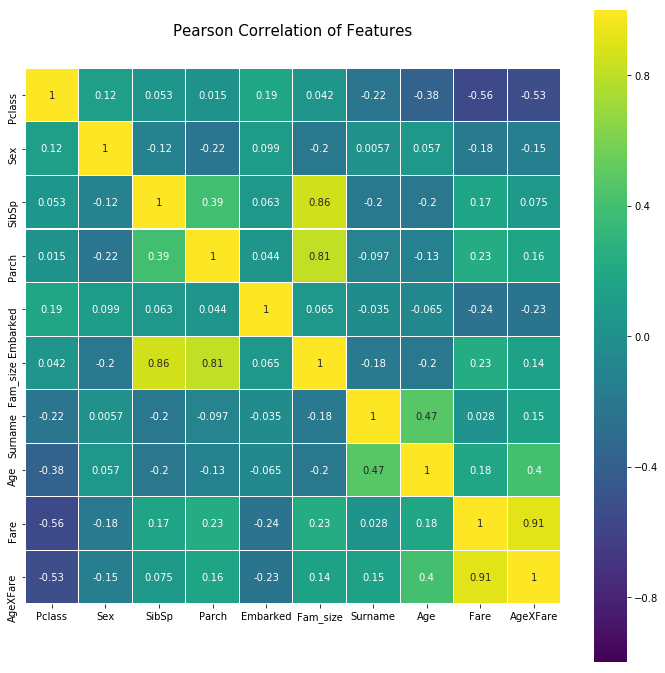

In [4]:
cmp = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_clean.drop(target, axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, vmin=-1.0, square=True, cmap=cmp, 
            linecolor='white', annot=True)

# Creating a better feature set

First examine the training set to compare survival rates and the data.

In [5]:
df = data_raw.dropna(subset=['Survived']).copy()
df_full = data_raw.copy()

## Family Size

Family size is a discrete quantitative variable. As such, this will not require 1-hot encoding.

First I will plot the survival rates at each discrete value in Parch, SibSp, and Fam size to see if there is a significant discrepancy.  Included is a plot of survival counts to show how heavy of a class imbalance there is in survival rates.

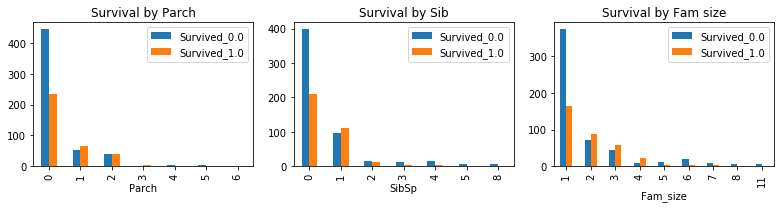

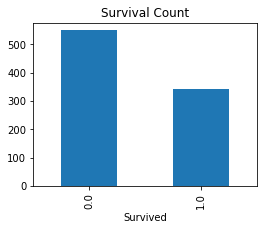

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(11, 3))

# Parch
df_parch = pd.get_dummies(df[['Parch', target]], columns=[target])
df_parch = df_parch.groupby('Parch').agg('sum').astype(int)
df_parch.plot.bar(ax=axs[0])
axs[0].set_title('Survival by Parch')

# SibSp
df_sib = pd.get_dummies(df[['SibSp', target]], columns=[target])
df_sib = df_sib.groupby('SibSp').agg('sum').astype(int)
df_sib.plot.bar(ax=axs[1])
axs[1].set_title('Survival by Sib')

# Fam size
df_fam = pd.get_dummies(df[['Fam_size', target]], columns=[target])
df_fam = df_fam.groupby('Fam_size').agg('sum').astype(int)
df_fam.plot.bar(ax=axs[2])
axs[2].set_title('Survival by Fam size')

fig.tight_layout()

# Survival count
fig = plt.figure(figsize=(4,3))

df['Survived'].value_counts().plot.bar(title='Survival Count')
plt.xlabel('Survived')

Looking at the Fam size graph, individuals with no family died at much higher rate than those with family members aboard. Since Parch and SibSp are heavily correlated with Fam size, I will remove them from the feature set. 

In [7]:
df_features = pd.DataFrame(df_full['Fam_size'].copy())

Next we will look at the effect of the survival rate among individuals who are alone against the survival rate of individuals with family members aboard and the survival rate among different sizes of families.

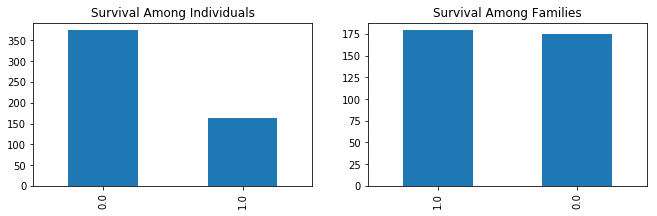

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3))

# Individuals
df_ind = df.loc[df['Fam_size'] == 1, 'Survived'].value_counts()
df_ind.plot.bar(ax=axs[0])
axs[0].set_title('Survival Among Individuals')

# With family
df_fam = df.loc[df['Fam_size'] > 1, 'Survived'].value_counts()
df_fam.plot.bar(ax=axs[1])
axs[1].set_title('Survival Among Families')

Passengers without any family died at a much higher rate than those with family aboard. I will add this as a feature.

In [9]:
df_features['Is_Alone'] = 0
df_features.loc[df_full['Fam_size'] == 1, 'Is_Alone'] = 1

It appears as if survival rate drops among individuals with a large amount of family aboard the ship but there is not a lot of data since large families are uncommon in the dataset.  Since this is the case, we will not add this feature.

In [10]:
large_family_percent = len(df_full.loc[df_full['Fam_size'] > 4]) / len(df_full) * 100
print('Passengers with 4+ family members aboard consist of {:.2f}% of the full data.'.format(large_family_percent))
print('In the training data...')
df.loc[df['Fam_size'] > 4, 'Survived'].value_counts()

Passengers with 4+ family members aboard consist of 6.26% of the full data.
In the training data...


0.0    52
1.0    10
Name: Survived, dtype: int64

## Cabin

The original data listed a cabin number on some passengers. Below is a graph comparing survival rate among passengers with and without a cabin designation.

22.90% of passengers have cabins.


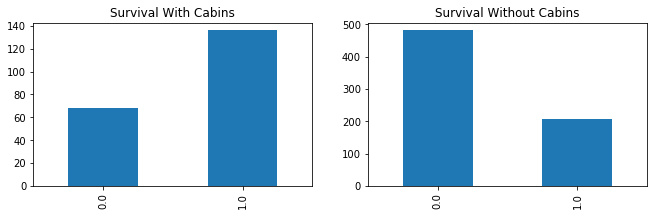

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3))

# Cabin
df_cab = df.loc[pd.notnull(df['Cabin']), 'Survived'].value_counts().sort_index()
df_cab.plot.bar(ax=axs[0])
axs[0].set_title('Survival With Cabins')

# No Cabin
df_no_cab = df.loc[pd.isnull(df['Cabin']), 'Survived'].value_counts()
df_no_cab.plot.bar(ax=axs[1])
axs[1].set_title('Survival Without Cabins')

print('{:.2f}% of passengers have cabins.'.format(df_cab.sum() / len(df) * 100))

Passengers without a cabin died at a higher rate so we will add this feature.

In [12]:
df_features['Has_cabin'] = 0
df_features.loc[pd.notnull(df_full['Cabin']), 'Has_cabin'] = 1

I wonder if people are sharing cabins or are cabins occupied by a single family. I will explore this below.

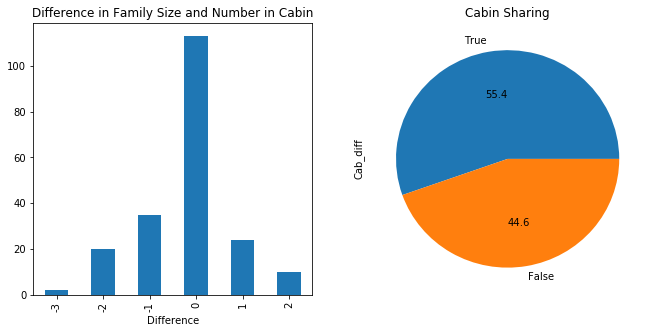

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))

# Diff
df['Num_in_cab'] = df.groupby(['Cabin'])['Fam_size'].transform('count')
df_cabin = df.loc[pd.notnull(df['Num_in_cab']), ['Num_in_cab', 'Fam_size', 'Survived']].astype(int)
df_cabin['Cab_diff'] = df_cabin['Num_in_cab'] - df_cabin['Fam_size']
ax = df_cabin['Cab_diff'].value_counts().sort_index().plot.bar(ax=axs[0], title='Difference in Family Size and Number in Cabin')
ax.set_xlabel('Difference')

# Cabin sharing
(df_cabin['Cab_diff'] == 0).value_counts().plot.pie(ax=axs[1], autopct='%.1f', title='Cabin Sharing')

Check and see if there is a difference in survival rates between those sharing a cabin and those not sharing a cabin.

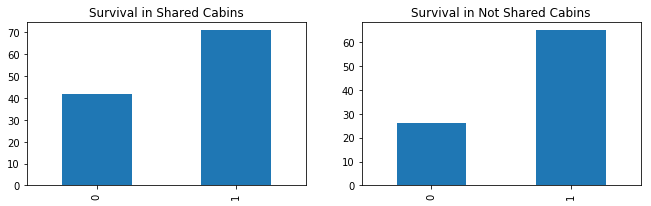

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3))

# Sharing
df_cabin.loc[df_cabin['Cab_diff'] == 0, 'Survived'].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Survival in Shared Cabins')

# No Cabin
df_cabin.loc[df_cabin['Cab_diff'] != 0, 'Survived'].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Survival in Not Shared Cabins')

I do not see a significant difference between survival rates between shared cabins and not shared cabins so I will not add any features.

We could perform the same analysis between cabin and class. My intuition is that the interaction may be important since weathly people are probably more likely to have a cabin but since only ~20% of passengers have cabins, I do not think the time needed to perform this analysis will be worth the effort.

## Names

We already performed cleaning to the surnames so I am just going to keep the work we originally did.

In [15]:
df_features['Names'] = df_full['Surname']

In [16]:
df_features['Names'].value_counts()

Mr.        757
Miss.      260
Mrs.       196
Master.     61
Rare        35
Name: Names, dtype: int64

## Fare

I will not add the interaction term that I previously used since it is heavily correlated with fare and so will not provide much new information.

Plotting fare...

Stats for Died
count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Died, dtype: float64


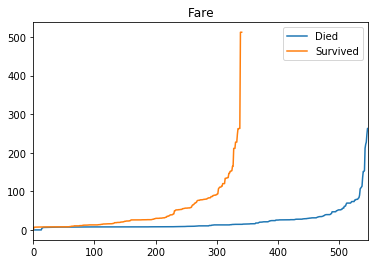

In [17]:
df_fare = pd.DataFrame()

df_fare['Died'] = df.loc[df[target] == 0, 'Fare'].sort_values().reset_index(drop=True)
df_fare['Survived'] = df.loc[df[target] == 1, 'Fare'].sort_values().reset_index(drop=True)
df_fare.plot.line(title='Fare')
print('Stats for Died')
print(df_fare['Died'].describe())

We see that at lower fare rates, it appears that passengers are more likely to die. We will use the median fare from all passengers and add this as a feature.

There is a missing value in test set so we will impute this value using the median fare. We will use a median since it is for more resistant to outliers and there are a number of very high fares that will skew the mean.

Median fare is 14.45
Survival rate among all passengers: 62.30%
Survival rate among poor passengers: 33.74%


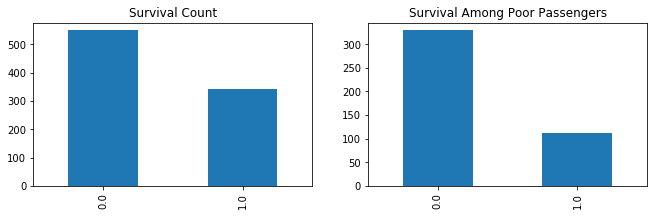

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3))

median_fare = df_full['Fare'].quantile(q=.5)
df_poor = df.loc[df['Fare'] < median_fare, target].value_counts()
df_sur = df['Survived'].value_counts()

print('Median fare is {:.2f}'.format(median_fare))
print('Survival rate among all passengers: {:.2f}%'.format(df_sur[1] / df_sur[0] * 100))
print('Survival rate among poor passengers: {:.2f}%'.format(df_poor[1] / df_poor[0] * 100))

# Total
df_sur.plot.bar(ax=axs[0])
axs[0].set_title('Survival Count')

# Poor
df_poor.plot.bar(ax=axs[1])
axs[1].set_title('Survival Among Poor Passengers')

Impute missing value.

In [19]:
print('Number of missing values: {}'.format(len(df_full.loc[pd.isnull(df_full['Fare'])])))
df_full.loc[pd.isnull(df_full['Fare']), 'Fare'] = df_full['Fare'].median()

Number of missing values: 1


Add poor feature and fare.

In [20]:
df_features['Is_cheap'] = 0
df_features.loc[df_full['Fare'] < median_fare, 'Is_cheap'] = 1

df_features['Fare'] = df_full['Fare'].copy().astype(int)

## Age

There is a lot of missing data in age and we will handle this by imputing values. We will use a gaussian distribution to randomly generate values. There are a number of outliners for newborns so we will proceed with caution.

In [21]:
age_avg = df_full['Age'].mean()
age_std = df_full['Age'].std()
age_null_count = df_full['Age'].isnull().sum()

age_rand = np.random.normal(age_avg, age_std, age_null_count).clip(min=0)

df_features['Age'] = df_full['Age'].copy()
df_features.loc[pd.isnull(df_features['Age']), 'Age'] = age_rand
df_features['Age'] = df_features['Age'].astype(int)

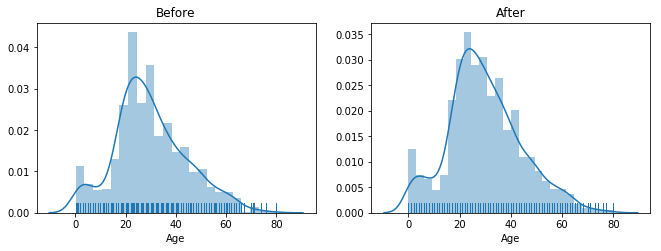

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3.5))

# Before
sns.distplot(df_full.loc[pd.notnull(df_full['Age']), 'Age'], kde=True, rug=True, ax=axs[0])
axs[0].set_title('Before')

# After
df_after = df_features['Age']
sns.distplot(df_after, kde=True, rug=True, ax=axs[1])
axs[1].set_title('After')

## Sex

We will check to see if there is a severe imbalance, otherwise we will just add it is.

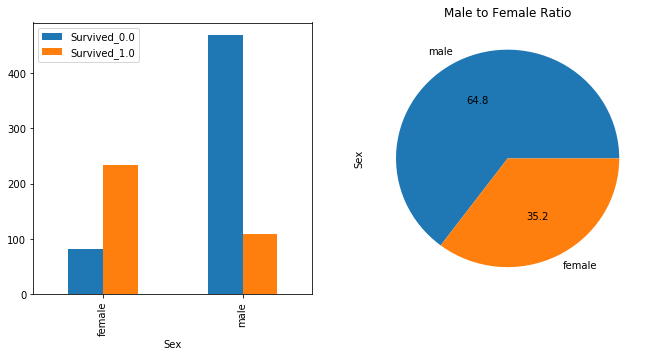

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))

# Sex
df_sex = pd.get_dummies(df[['Sex', target]], columns=[target])
df_sex = df_sex.groupby('Sex').agg('sum').astype(int)
df_sex.plot.bar(ax=axs[0])

# Ratio
df['Sex'].value_counts().plot.pie(ax=axs[1], autopct='%.1f', title='Male to Female Ratio')

There weremore males on board and they died at a much higher rate than female passengers. There is nothing more we need to add to the features.

In [24]:
df_features['Sex'] = 0
df_features.loc[df_full['Sex'] == 'male', 'Sex'] = 1

## Ticket

I am not able to discern any information from the ticket names so I will not add the column to the feature list.

## Embarked

We will compare the survival rates among the three different classes.

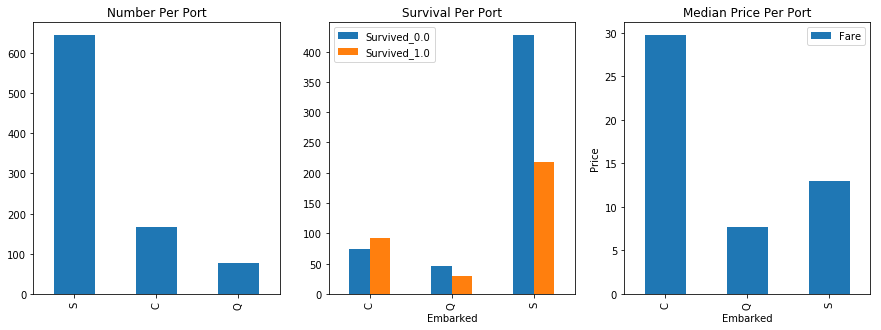

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Total train set counts
df_emb_total = df['Embarked'].value_counts()
df_emb_total.plot.bar(ax=axs[0])
axs[0].set_title('Number Per Port')

# Survival Rates
df_emb = pd.get_dummies(df[['Embarked', target]], columns=[target])
df_emb = df_emb.groupby('Embarked').agg('sum').astype(int)
df_emb.plot.bar(ax=axs[1])
axs[1].set_title('Survival Per Port')

# Median fare
df[['Embarked', 'Fare']].groupby('Embarked').agg('median').plot.bar(ax=axs[2])
axs[2].set_ylabel('Price')
axs[2].set_title('Median Price Per Port')

As we would expect from the previous fare analysis, passengers who paid less were more likely to die.  We will add this feature into our data.

In [26]:
df_features['Port'] = df_full['Embarked'].copy()

## Pclass

Last but not least, we will look at the passenger class.  From the second attempt, we understand that the greater the passenger class, the more likely the passenger was to survive.

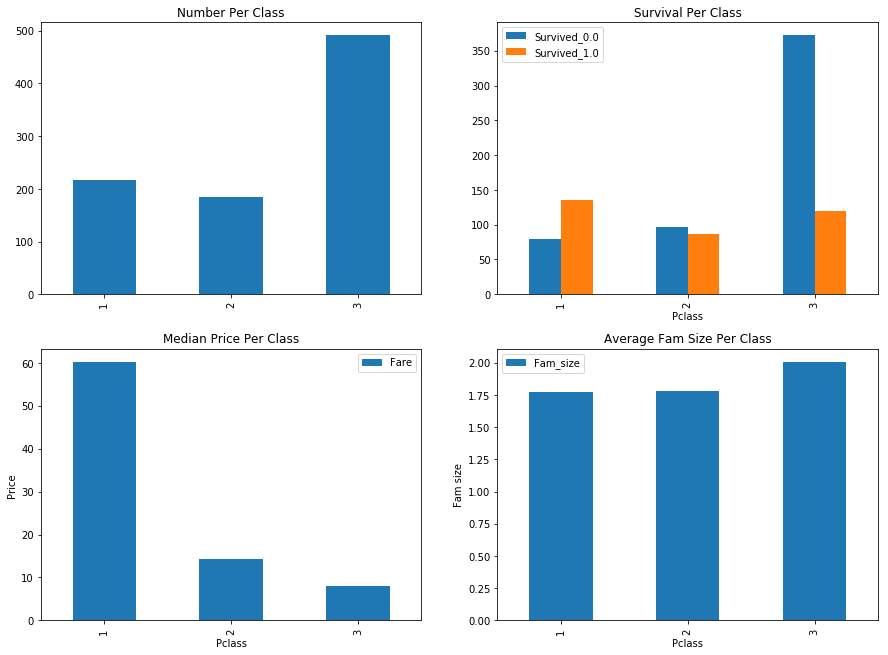

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

# Total train set counts
df_class_total = df['Pclass'].value_counts().sort_index()
df_class_total.plot.bar(ax=axs[0,0])
axs[0,0].set_title('Number Per Class')

# Survival Rates
df_class = pd.get_dummies(df[['Pclass', target]], columns=[target])
df_class = df_class.groupby('Pclass').agg('sum').astype(int)
df_class.plot.bar(ax=axs[0,1])
axs[0,1].set_title('Survival Per Class')

# Median fare (Not needed but was easy to copy so why not)
df[['Pclass', 'Fare']].groupby('Pclass').agg('median').plot.bar(ax=axs[1,0])
axs[1,0].set_ylabel('Price')
axs[1,0].set_title('Median Price Per Class')

# Average fam size (Not needed but was easy to copy so why not)
df[['Pclass', 'Fam_size']].groupby('Pclass').agg('mean').plot.bar(ax=axs[1,1])
axs[1,1].set_ylabel('Fam size')
axs[1,1].set_title('Average Fam Size Per Class')

Lower class passengers died at higher rates than classes greater than their own. The lowest class passengers had higher average family sizes but also had the cheapest tickets.  Since this data is categorical, I wonder if it would make the ```Is_cheap``` feature unnecessary.  After encoding, we will look once more at the pearson correlation heatmap and decided whether we wish to keep it or not.

In [28]:
df_features['Pclass'] = df_full['Pclass'].copy()

# Feature Encoding

Categorical features will be encoded using 1-hot and quantitative will be left as is. As will be assigned numeric labels if not already so.

In [29]:
categorical_non_bin_labels = ['Names', 'Port', 'Pclass']
categorical_bin_labels = ['Is_Alone', 'Has_cabin', 'Is_cheap', 'Sex']
discrete_labels = ['Fam_size']
continuous_labels = ['Fare', 'Age']

1-Hot encode categorical non binary features.

In [30]:
df_features = pd.get_dummies(df_features, columns=categorical_non_bin_labels)

# Visualization

We will once again use a pearson correlation to perform some last minute feature selection.

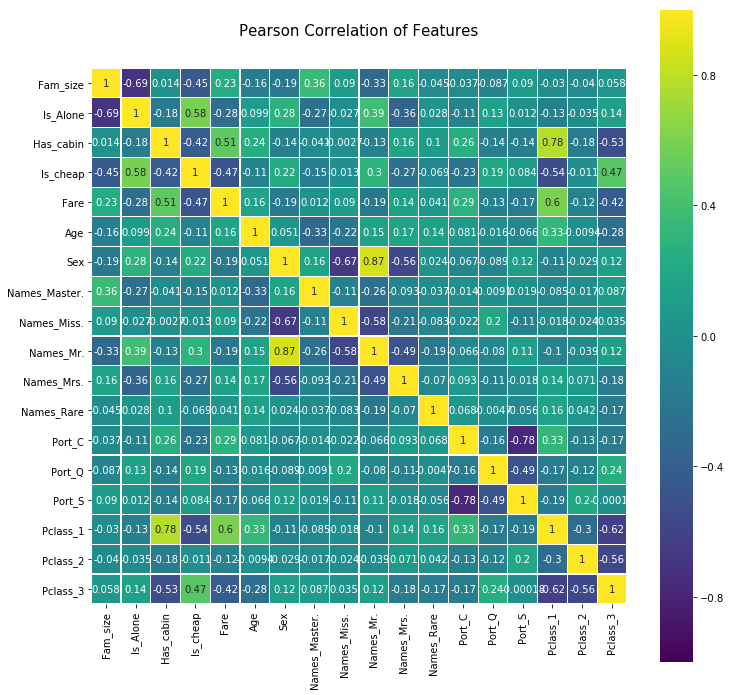

In [31]:
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_features.astype(float).corr(),linewidths=0.1,vmax=1.0, vmin=-1.0, square=True, cmap=cmp, 
            linecolor='white', annot=True)

We will leave our features in the set although I thought that it was interesting that the surname could used to determine the sex of the passenger. This would mean that the sex feature would not be providing any new information. In addition, there is strong correlation between Pclass 1 and whether the passenger has a cabin.  Still, I will leave these in the dataset.

# Saving The Features

In [34]:
# Add in the survivor labels
df_features[target] = df_full[target].copy()

# Add in Passenger labels
df_features['Id'] = df_full['PassengerId']

df_features.to_csv('../data/features.csv')